# Modelo 01

<hr>

## Cleaning and Processing Machine Learning data

In [16]:
import pandas as pd
import os
import json

pd.set_option('display.max_columns', None)

In [17]:
df_houses = pd.read_json('../Scraping/Output/Data/data_edomex_apartments.json')
df_apartments = pd.read_json('../Scraping/Output/Data/data_edomex_houses.json')

In [18]:
df_complete = df_houses.append(df_apartments)
# df_complete

In [19]:
df_complete = df_complete[df_complete['currency']=="MXN"]
df_complete.head()

,url,type_of_offer,type_of_prop,name,price,currency,Estado,Ciudad,Colonia,Superficie total,Superficie construida,Antiguedad,Ambientes,Recamaras,Banos,Estacionamientos,Cantidad de pisos,Departamentos por piso,Número de piso de la unidad,Bodegas,Cuota mensual de mantenimiento,Disposición,Orientación,Tipo de departamento,Tipo de casa,Tipo de propiedad
0,https://departamento.metroscubicos.com/MLM-959...,sale,apartments,Departamentos En View Bosque Real,36570,MXN,Estado De México,Huixquilucan,Bosque Real,202.0,202.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://departamento.metroscubicos.com/MLM-959...,sale,apartments,Departamento En Venta En Interlomas Residencia...,3200000,MXN,Estado De México,Huixquilucan,Interlomas,130.0,130.0,2013.0,6.0,3.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://departamento.metroscubicos.com/MLM-958...,sale,apartments,"Venta Departamento En Bosques De Las Palmas, H...",5369000,MXN,Estado De México,Huixquilucan,Bosques De Las Palmas,160.0,160.0,NaN,NaN,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://departamento.metroscubicos.com/MLM-941...,sale,apartments,"Departamento En Venta En Interlomas, El Roble",5500000,MXN,Estado De México,Huixquilucan,Interlomas,148.0,148.0,18.0,5.0,2.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://departamento.metroscubicos.com/MLM-846...,sale,apartments,Av. Adolfo López Mateos Jesús Del Monte,3200000,MXN,Estado De México,Huixquilucan,Jesús Del Monte,126.0,126.0,NaN,NaN,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Split data Train and Test

In [20]:
from sklearn.model_selection import train_test_split

# Read data
X_full = df_complete
# X_test_full = pd.read_csv("")

# Obtain Target and Predictions
y = X_full.price

features = ['type_of_prop',
       'Estado', 'Ciudad', 'Colonia', 'Superficie total','Ambientes', 'Recamaras', 'Banos',
       'Estacionamientos', 'Antiguedad', 'Cantidad de pisos',
       'Cuota mensual de mantenimiento', 'Bodegas']

X = X_full[features]
# X_test = X_test_full[features]

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


In [21]:
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

## 1) Cleaning

We require the transformation of Categorical Variables to feed the model, we will use One Hot Encoder because the variables we need to transform do not have an ordinal rank, and we don´t need to identify a hierarchy level between houses and apartments, for example. 

### Categorical Variables

In [22]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['type_of_prop', 'Estado', 'Ciudad', 'Colonia']


### One Hot Encoding

In [23]:
from sklearn.preprocessing import OneHotEncoder

s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)


### Goodbye NAs 

In [24]:
OH_X_train=OH_X_train.fillna(0)
OH_X_valid=OH_X_valid.fillna(0)

print("No more NAs, now just 0s :D")

No more NAs, now just 0s :D


In [25]:
from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=OH_X_train, X_v=OH_X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 1542548
Model 2 MAE: 1554688
Model 3 MAE: 1562822
Model 4 MAE: 1618402
Model 5 MAE: 1572419


## 2) Cross Validation

Cross Validation is used to improve the score measures of our model by running the same process on different subsets of data to get multiple scores, or in other workds, desing different scenarios in order to use the 100% of the dataset as a test or validation data. This method should be used if we have a relative small data set.

In [20]:
# Creating a Pipeline

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

In [21]:
from sklearn.model_selection import cross_val_score
X=X.fillna(0)

# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)

# Encoding Categorical Variables with OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_X_pandas = pd.get_dummies(X)

# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols = pd.DataFrame(OH_encoder.fit_transform(X[object_cols]))
# One-hot encoding removed index; put it back
# OH_cols.index = X.index
# Remove categorical columns (will replace with one-hot encoding)
# num_X = X.drop(object_cols, axis=1)
# Add one-hot encoded columns to numerical features
# OH_X = pd.concat([num_X, OH_cols], axis=1)

# Verify if NA cleaning can be inside the pipeline
# OH_X=OH_X.fillna(0)

def crossed_score_model(model, X, y):
    
    my_pipeline = Pipeline(steps=[('model', model)])
    
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
#     print("MAE scores:\n", scores)
#     print(scores.mean())
    return scores.mean()

for i in range(0,len(models)):
    cross_score=crossed_score_model(models[i],OH_X_pandas, y)
    print("Model %d Avg Cross Score: %d" % (i+1, cross_score))
    

Model 1 Avg Cross Score: 1742031
Model 2 Avg Cross Score: 1749608
Model 3 Avg Cross Score: 1764095
Model 4 Avg Cross Score: 1783710
Model 5 Avg Cross Score: 1805942


## 3) XG Boost

Gradient boosting is a method that goes through cycles to iteratively add models into an ensemble.


It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.)

In [22]:
OH_X_train.head()

,Superficie total,Ambientes,Recamaras,Banos,Estacionamientos,Antiguedad,Cantidad de pisos,Cuota mensual de mantenimiento,Bodegas,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163
55,130.0,0.0,3.0,3.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,238.0,0.0,3.0,3.0,4.0,3.0,3.0,1200.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,68.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
124,692.0,0.0,4.0,4.0,6.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54,320.0,7.0,3.0,3.0,4.0,19.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [23]:
OH_X_train = pd.read_json('../Scraping/Output/full_data.json')

OH_X_train[OH_X_train['Estado']=="Queretaro"]['type_of_prop'].value_counts()

houses    11
Name: type_of_prop, dtype: int64

In [29]:
from xgboost import XGBRegressor
X_valid 

# xg_model = XGBRegressor()
# xg_model.fit(OH_X_train, y_train)

from sklearn.metrics import mean_absolute_error

# Get predictions
# predictions = xg_model.predict(OH_X_valid) 
# mae = mean_absolute_error(predictions, y_valid) 

print(mae)

1572419.792244786


In [ ]:
print("MAE still very high :(")

## Models

In [2]:
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

## Feeding model with All States Data Set

In [3]:
df_data = pd.read_json('../Resources/distrito_federal.json')
edomex_data = pd.read_json('../Resources/estado_de_mexico.json')

In [4]:
national_data = pd.read_json('../Scraping/Output/full_data.json')
national_data = national_data[national_data['currency']=='MXN']
national_data = national_data[national_data['name'].str.contains('Renta')==False]
national_data = national_data[national_data['cp'].isnull()==False]
len(national_data)

2383

In [5]:
# national_data['Estado'].value_counts()

In [6]:
national_data = national_data.append(edomex_data)
national_data = national_data.append(df_data)
national_data.reset_index(inplace = True)
national_data.to_csv("national_data_complete.csv")
len(national_data)

3128

In [41]:
# df_data.head()

In [8]:
national_data = pd.read_json('../Scraping/Output/full_data.json')
national_data = national_data[national_data['price']<8000000]
national_data = national_data[national_data['Superficie total']<300]
national_data = national_data[national_data['Estado']=='Puebla']


<AxesSubplot:>

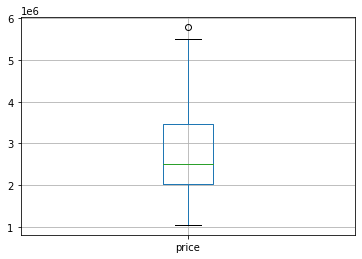

In [9]:
national_data = pd.read_json('../Scraping/Output/full_data.json')
national_data = national_data[national_data['currency']=='MXN']
national_data = national_data[national_data['name'].str.contains('Renta')==False]
national_data = national_data[national_data['cp'].isnull()==False]

national_data = national_data[national_data['price']>1000000]
national_data = national_data[national_data['price']<10000000]
national_data = national_data[national_data['Estado']=='Puebla']
national_data = national_data[national_data['Superficie total']<300]

national_data['price'].plot.box(grid='True')



In [ ]:
    X_full = data
    y = X_full.price
    features = ['type_of_prop','cp', 'Superficie total','Superficie construida', 'Ambientes', 'Recamaras', 'Banos','Estacionamientos', 'Antiguedad', 'Cantidad de pisos','Cuota mensual de mantenimiento', 'Bodegas']
    X = X_full[features]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

    

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn import metrics

# Function to return everything
def machine_learning_model(data, model):
    X_full = data
    y = X_full.price
    features = ['type_of_prop','cp', 'Superficie total','Superficie construida', 'Ambientes', 'Recamaras', 'Banos','Estacionamientos', 'Antiguedad', 'Cantidad de pisos','Cuota mensual de mantenimiento', 'Bodegas']
    X = X_full[features]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
    
    #One Hot Encoding  
    s = (X_train.dtypes == 'object')
    object_cols = list(s[s].index)
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
    OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))
    OH_cols_train.index = X_train.index
    OH_cols_valid.index = X_valid.index
    num_X_train = X_train.drop(object_cols, axis=1)
    num_X_valid = X_valid.drop(object_cols, axis=1)
    OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
    OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

    columns = OH_X_valid.columns
    # Remove NAs
    OH_X_train=OH_X_train.fillna(0)
    OH_X_valid=OH_X_valid.fillna(0)
    
    # Fit Model
    model.fit(OH_X_train, y_train)
    prediction = model.predict(OH_X_valid)
 
    #Performance Metrics 
    mae = mean_absolute_error(y_valid, prediction)
    score = round(model.score(OH_X_valid, y_valid)*100,2)
    mape = round(np.mean(np.abs((y_valid - prediction) / np.abs(y_valid))),2)
    acc = round(100*(1 - mape), 2)
    rmse = np.sqrt(metrics.mean_squared_error(y_valid, prediction))
    
    results={'mae':mae,
             'mape':mape,
             'accuracy':acc,
             'rmse':rmse
             
            }
    
    return results, columns

model = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=3)
# model.fit(OH_X_train, y_train)

# national_data = pd.read_json('../Scraping/Output/full_data.json')
# national_data = national_data[national_data['currency']=='MXN']
# national_data = national_data[national_data['name'].str.contains('Renta')==False]
# national_data = national_data[national_data['cp'].isnull()==False]
# national_data = national_data[national_data['price']>1000000]
# national_data = national_data[national_data['price']<10000000]
# national_data = national_data[national_data['Superficie total']<300]
# data = national_data[national_data['Estado']=='Puebla']
results, columns = machine_learning_model(national_data, model)
results

{'mae': 358304.09724175575,
 'mape': 0.13,
 'accuracy': 87.0,
 'rmse': 528468.7168227575}

In [12]:

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, prediction)))

NameError: name 'y_valid' is not defined

In [30]:
X_full = national_data
y = X_full.price
features = ['type_of_prop','cp', 'Superficie total','Superficie construida', 'Ambientes', 'Recamaras', 'Banos','Estacionamientos', 'Antiguedad', 'Cantidad de pisos','Cuota mensual de mantenimiento', 'Bodegas']
X = X_full[features]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

columns = OH_X_valid.columns
# Remove NAs
OH_X_train=OH_X_train.fillna(0)
OH_X_valid=OH_X_valid.fillna(0)

OH_X_valid

,cp,Superficie total,Superficie construida,Ambientes,Recamaras,Banos,Estacionamientos,Antiguedad,Cantidad de pisos,Cuota mensual de mantenimiento,Bodegas,0,1
2495,66634.0,74.0,74.00,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2533,64988.0,136.0,295.00,7.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
2465,66480.0,119.0,119.00,6.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
2534,64349.0,152.0,291.00,7.0,3.0,3.0,2.0,7.0,0.0,0.0,0.0,0.0,1.0
2458,66422.0,120.0,120.00,10.0,3.0,2.0,2.0,17.0,1.0,750.0,0.0,1.0,0.0
2571,64102.0,90.0,186.00,0.0,3.0,5.0,0.0,11.0,0.0,0.0,0.0,0.0,1.0
2759,67140.0,95.0,194.00,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2597,64650.0,144.0,320.00,8.0,3.0,4.0,2.0,18.0,0.0,0.0,0.0,0.0,1.0
2679,67302.0,215.0,355.00,8.0,3.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
2619,64985.0,280.0,280.00,0.0,3.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
columns

Index([                            'cp',               'Superficie total',
                'Superficie construida',                      'Ambientes',
                            'Recamaras',                          'Banos',
                     'Estacionamientos',                     'Antiguedad',
                    'Cantidad de pisos', 'Cuota mensual de mantenimiento',
                              'Bodegas',                                0,
                                      1],
      dtype='object')

In [86]:
cp_default = 52172
surface_Cons_default = ''
surfaceTot_default = ''
room_default = ''
parkinglot_default = ''
antiguedad_default = ''
enviroment_default = ''

type_property=0

In [87]:
floor_default = national_data['Cantidad de pisos'].mode()
bodegas_default = national_data['Bodegas'].mode()
bathroom_default = national_data['Banos'].mode()
mantenimiento_default = national_data['Cuota mensual de mantenimiento'].mode()
house_default = 1
apartment_default = 0

if cp_default == '': 
    cp_default = national_data['cp'].mode()
if surface_Cons_default == '': 
    surface_Cons_default = national_data['Superficie construida'].mode()
if room_default == '': 
    room_default = national_data['Recamaras'].mode()
if parkinglot_default == '': 
    parkinglot_default = national_data['Estacionamientos'].mode()
if surfaceTot_default == '': 
    surfaceTot_default = national_data['Superficie total'].mode()
if antiguedad_default == '': 
    antiguedad_default = national_data['Antiguedad'].mode()
if enviroment_default == '': 
    enviroment_default = national_data['Ambientes'].mode()   
if type_property == 1:
    house_default = 0
    apartment_default = 1
    
input_prediction = pd.DataFrame({'cp':cp_default, 'Superficie construida':surface_Cons_default,'Recamaras': room_default, 
                                 'Estacionamientos': parkinglot_default, 'Cantidad de pisos':floor_default,
                                 'Bodegas':bodegas_default, 'Superficie total':surfaceTot_default, 'Ambientes':enviroment_default,
                                 'Banos':bathroom_default, 'Antiguedad':antiguedad_default, 'Cuota mensual de mantenimiento':mantenimiento_default,
                                '0':house_default,'1':apartment_default})
input_prediction


,cp,Superficie construida,Recamaras,Estacionamientos,Cantidad de pisos,Bodegas,Superficie total,Ambientes,Banos,Antiguedad,Cuota mensual de mantenimiento,0,1
0,52172,119.0,3.0,2.0,2.0,1.0,90.0,4.0,2.0,0.0,0.0,1,0


In [96]:
# model.predict(input_prediction)
prediction_result = model.predict(input_prediction)

results = pd.DataFrame({'Prediction':prediction_result[0]},index=[0])
results

,Prediction
0,4.563750e+06


In [46]:
national_data['Estado'].unique()

array(['Nuevo León'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

# Read data
X_full = national_data
# X_test_full = pd.read_csv("")

# Obtain Target and Predictions
y = X_full.price

features = ['type_of_prop','cp', 'Superficie total',
       'Superficie construida', 'Ambientes', 'Recamaras', 'Banos',
       'Estacionamientos', 'Antiguedad', 'Cantidad de pisos',
       'Cuota mensual de mantenimiento', 'Bodegas']

X = X_full[features]

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


In [28]:
from sklearn.preprocessing import OneHotEncoder

s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

OH_X_train=OH_X_train.fillna(0)
OH_X_valid=OH_X_valid.fillna(0)

In [29]:
from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=OH_X_train, X_v=OH_X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    mea = mean_absolute_error(y_v, preds)
    return mea, preds

for i in range(0, len(models)):
    try:
        mae = score_model(models[i])[0]
        print("Model %d MAE: %d" % (i+1, mae))
        preds = score_model(models[i])[1]
        
    except Exception as e:
        print(e)

Model 1 MAE: 687104
Model 2 MAE: 690212
Model 3 MAE: 698462
Model 4 MAE: 768528
Model 5 MAE: 805611


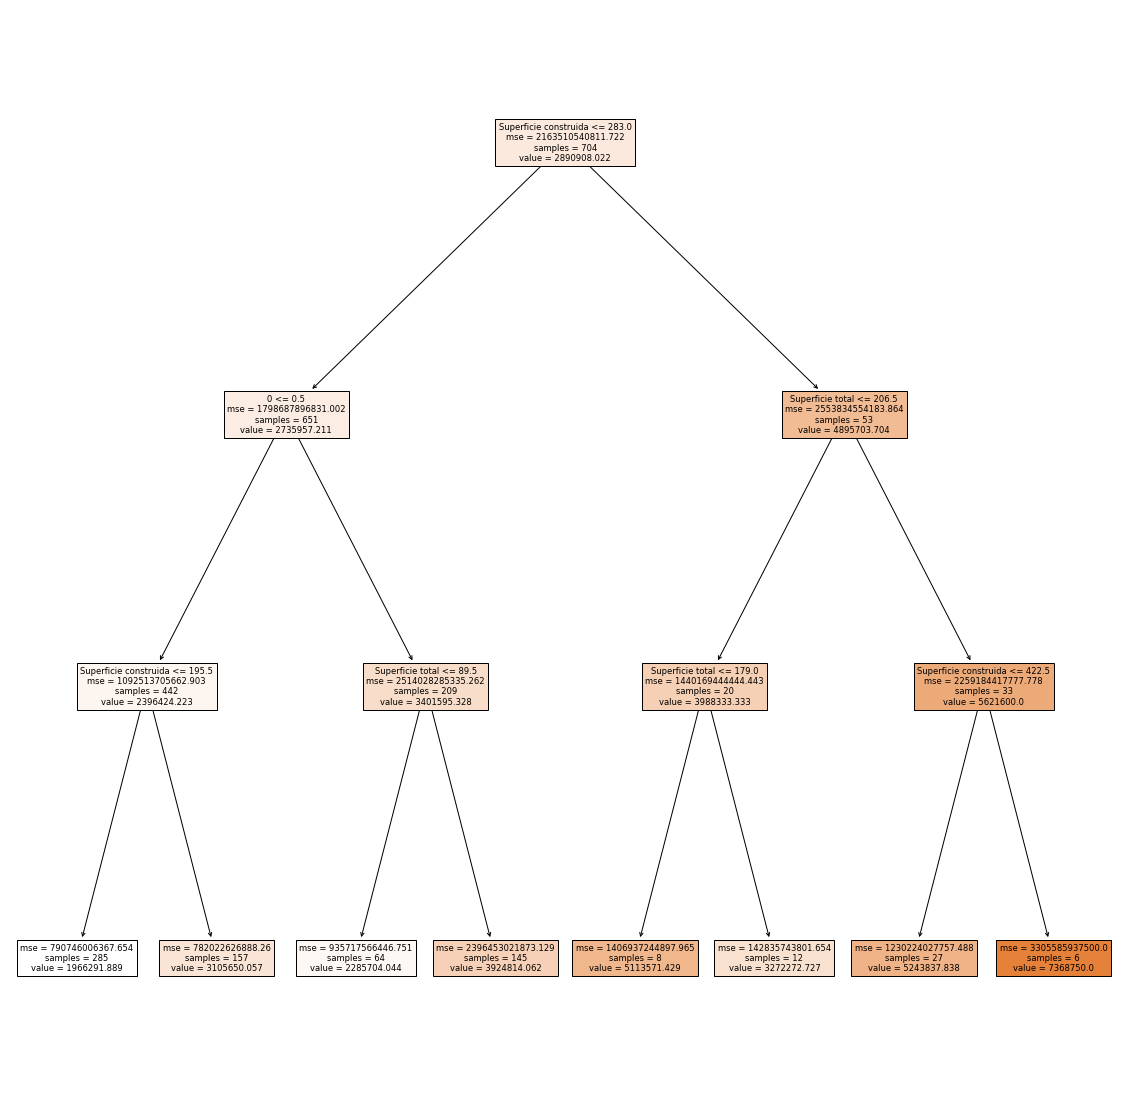

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import f1_score

# from dtreeviz.trees import dtreeviz # will be used for tree visualization
from matplotlib import pyplot as plt

model_2 = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=3)
model_2.fit(OH_X_train, y_train)
predictions = model_2.predict(OH_X_valid)

# print(mean_absolute_error(y_valid, predictions))

plt.figure(figsize=(20,20))
_ = tree.plot_tree(model_2.estimators_[0], feature_names = OH_X_train.columns, filled=True)

In [34]:
model_2.feature_importances_

array([1.08289927e-02, 1.69096284e-01, 5.74565343e-01, 2.45888164e-03,
       3.70330052e-03, 5.54377496e-03, 3.16251240e-03, 4.54644761e-04,
       2.60170623e-03, 0.00000000e+00, 0.00000000e+00, 1.23749830e-01,
       1.03834729e-01])

In [50]:
features

Index([                            'cp',               'Superficie total',
                'Superficie construida',                      'Ambientes',
                            'Recamaras',                          'Banos',
                     'Estacionamientos',                     'Antiguedad',
                    'Cantidad de pisos', 'Cuota mensual de mantenimiento',
                              'Bodegas',                                0,
                                      1],
      dtype='object')

In [49]:
model_2.feature_importances_

array([1.08289927e-02, 1.69096284e-01, 5.74565343e-01, 2.45888164e-03,
       3.70330052e-03, 5.54377496e-03, 3.16251240e-03, 4.54644761e-04,
       2.60170623e-03, 0.00000000e+00, 0.00000000e+00, 1.23749830e-01,
       1.03834729e-01])

In [62]:
df['Importance']

0     0.010829
1     0.169096
2     0.574565
3     0.002459
4     0.003703
5     0.005544
6     0.003163
7     0.000455
8     0.002602
9     0.000000
10    0.000000
11    0.123750
12    0.103835
Name: Importance, dtype: float64

In [137]:
df

,Features,Importance
0,Cuota mensual de mantenimiento,0.000000
1,Bodegas,0.000000
2,Antiguedad,0.000455
3,Ambientes,0.002459
4,Cantidad de pisos,0.002602
5,Estacionamientos,0.003163
6,Recamaras,0.003703
7,Banos,0.005544
8,cp,0.010829
9,1,0.103835


In [162]:
df[df.iloc[:, 0] == 1].index

Int64Index([9], dtype='int64')

In [144]:
float(df[df.iloc[:, 0] == 1]['Importance'])

0.1038347291683062

In [163]:
weight=float(float(df[df.iloc[:, 0] == 0]['Importance']))+float(float(df[df.iloc[:, 0] == 1]['Importance']))
new_row=pd.DataFrame({'Features':'Tipo','Importance':weight},index=[0])
df = df.append(new_row)
df.drop(labels=df[df.iloc[:, 0] == 1].index, axis=0, inplace=True)
df.drop(labels=df[df.iloc[:, 0] == 0].index, axis=0, implace=True)
df

,Features,Importance
0,Cuota mensual de mantenimiento,0.000000
1,Bodegas,0.000000
2,Antiguedad,0.000455
3,Ambientes,0.002459
4,Cantidad de pisos,0.002602
5,Estacionamientos,0.003163
6,Recamaras,0.003703
7,Banos,0.005544
8,cp,0.010829
10,0,0.123750


In [171]:
mae=2
mape=2
acc=2
score=2

results={'mae':mae,'mape':mape,'accuracy':acc,'score':score}

In [180]:
features = OH_X_valid.columns

df=pd.DataFrame({'Features':features, 'Importance':model_2.feature_importances_}).sort_values("Importance").reset_index(drop=True)
weight=float(float(df[df.iloc[:, 0] == 0]['Importance']))+float(float(df[df.iloc[:, 0] == 1]['Importance']))
new_row=pd.DataFrame({'Features':'Tipo','Importance':weight},index=[0])
df = df.append(new_row)
df.drop(labels=df[df.iloc[:, 0] == 1].index, axis=0, inplace=True)
df.drop(labels=df[df.iloc[:, 0] == 0].index, axis=0, inplace=True)
df.sort_values("Importance", inplace=True)

dict_df = df.to_dict()

results['features_importance'] = dict_df

# df.plot.barh(x='Features', y='Importance')
results

{'mae': 2,
 'mape': 2,
 'accuracy': 2,
 'score': 2,
 'features_importance': {'Features': {0: 'Tipo',
   1: 'Bodegas',
   2: 'Antiguedad',
   3: 'Ambientes',
   4: 'Cantidad de pisos',
   5: 'Estacionamientos',
   6: 'Recamaras',
   7: 'Banos',
   8: 'cp',
   11: 'Superficie total',
   12: 'Superficie construida'},
  'Importance': {0: 0.22758455943143652,
   1: 0.0,
   2: 0.00045464476132175676,
   3: 0.002458881636135616,
   4: 0.002601706229777583,
   5: 0.003162512402010026,
   6: 0.0037033005226371814,
   7: 0.005543774960329945,
   8: 0.010828992736939082,
   11: 0.1690962843765676,
   12: 0.5745653429428447}}}

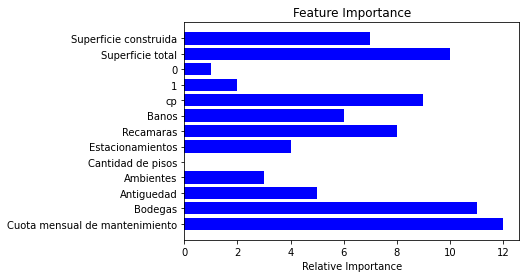

In [45]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestRegressor
import numpy as np

model_2 = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=3)
model_2.fit(OH_X_train, y_train)



features = OH_X_valid.columns
indices = np.argsort(model_2.feature_importances_)
y = range(len(indices))
width = importances[indices]

plt.title('Feature Importance')
plt.barh(y, width , color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## KNearest Neighbor Model

k: 1, Train/Test Score: 0.969/0.086
k: 3, Train/Test Score: 0.371/0.067
k: 5, Train/Test Score: 0.246/0.057
k: 7, Train/Test Score: 0.177/0.038
k: 9, Train/Test Score: 0.156/0.029
k: 11, Train/Test Score: 0.151/0.048
k: 13, Train/Test Score: 0.139/0.048
k: 15, Train/Test Score: 0.122/0.048
k: 17, Train/Test Score: 0.120/0.048
k: 19, Train/Test Score: 0.110/0.048


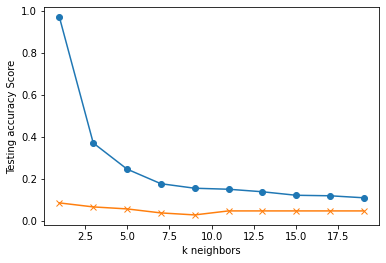

In [26]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties

train_scores = []
test_scores = []

for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(OH_X_train, y_train)
    train_score = knn.score(OH_X_train, y_train)
    test_score = knn.score(OH_X_valid, y_valid)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

k= 1  Test Acc: 0.086
MAE:  2003393.9238095237
RMSE:  3264818.3821218424
k= 2  Test Acc: 0.067
MAE:  2331294.933333333
RMSE:  3710776.0366700166
k= 3  Test Acc: 0.067
MAE:  2618571.0761904763
RMSE:  3979855.9640698805
k= 4  Test Acc: 0.057
MAE:  2776865.438095238
RMSE:  4267769.75250769
k= 5  Test Acc: 0.057
MAE:  2838318.819047619
RMSE:  4308059.475869463
k= 6  Test Acc: 0.048
MAE:  2856838.5428571426
RMSE:  4410312.883802782
k= 7  Test Acc: 0.038
MAE:  2890243.6380952382
RMSE:  4455516.933403007
k= 8  Test Acc: 0.029
MAE:  2909446.3238095236
RMSE:  4641587.134093746
k= 9  Test Acc: 0.029
MAE:  2952119.0095238094
RMSE:  4688272.247992313
k= 10  Test Acc: 0.029
MAE:  2949527.238095238
RMSE:  4695116.586837076
k= 11  Test Acc: 0.048
MAE:  2954066.504761905
RMSE:  4743331.385500742
k= 12  Test Acc: 0.048
MAE:  2976345.6666666665
RMSE:  4795936.56716221
k= 13  Test Acc: 0.048
MAE:  2892875.5523809525
RMSE:  4722352.966221883
k= 14  Test Acc: 0.048
MAE:  2967329.3238095236
RMSE:  4864280.2

Text(0, 0.5, 'Mean Absolute Error')

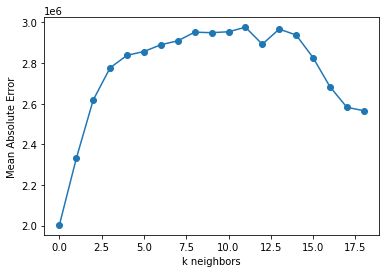

In [29]:
from sklearn.neighbors import KNeighborsClassifier
# Note that k: 5 provides the best accuracy where the classifier starts to stablize
def KN_model(n_neighbors):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(OH_X_train, y_train)
    print(f'k= {n_neighbors}  Test Acc: %.3f' % knn.score(OH_X_valid, y_valid))

    predictions_kn = knn.predict(OH_X_valid)
    mean_absolute_error_kn = mean_absolute_error(predictions_kn,y_valid)
    rmse = np.sqrt(metrics.mean_squared_error(predictions_kn,y_valid))
    
    print("MAE: ", mean_absolute_error_kn)
    print("RMSE: ", rmse)
    return mean_absolute_error_kn

results={}
response=[]

for i in range(1,20):
#     results[i] = KN_model(i)
    response.append(KN_model(i))

plt.plot(response, marker='o')
plt.xlabel("k neighbors")
plt.ylabel("Mean Absolute Error")

In [28]:
# Note that k: 5 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(OH_X_train, y_train)
print('k=5 Test Acc: %.3f' % knn.score(OH_X_valid, y_valid))

k=5 Test Acc: 0.057


In [ ]:
rmse = np.sqrt(metrics.mean_squared_error(y_valid, prediction))

In [ ]:
national_data[national_data['price']>100000000]